In [10]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler,  LabelEncoder, OneHotEncoder

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-processing Data

In [33]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [34]:
df['acc_ratio'] = df['acc_now_delinq'] / df['open_acc']

In [35]:
df = df.drop(columns=['delinq_amnt', 'out_prncp', 'out_prncp_inv', 'acc_now_delinq', 'funded_amnt_inv'])

In [36]:
df_proc = df.copy()

In [37]:
df_proc.loc[df_proc['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df_proc.loc[df_proc['annual_inc']>480000, 'annual_inc'] = 480000
df_proc.loc[df_proc['revol_bal']>290000, 'revol_bal'] = 290000
df_proc.loc[df_proc['revol_util']>1.785, 'revol_util'] = 1.785
df_proc.loc[df_proc['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df_proc.loc[df_proc['total_acc']>89, 'total_acc'] = 89
df_proc.loc[df_proc['open_acc']>41, 'open_acc'] = 41
df_proc.loc[df_proc['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008

In [38]:
# 구간으로 축약하기 (13개) // aux(auxiliary) = 보조의
auxtotal_rec_int = pd.cut(df_proc['total_rec_int'], 6) 
auxint_rate = pd.cut(df_proc['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df_proc['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df_proc['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df_proc['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df_proc['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df_proc['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df_proc['revol_util'], 10)  # 처음 2구간에 몰려있음
auxtotal_acc = pd.cut(df_proc['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df_proc['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df_proc['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfico_range_high = pd.cut(df_proc['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df_proc['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.

# aux_list 13개
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [39]:
# df_proc_2 부터는 구간 라벨링 시작
df_proc_2 = df_proc.copy()

In [40]:
# Label넣어줄 리스트 생성
col_for_label = ['total_rec_int', 'int_rate',  'installment', 'tot_cur_bal',
                 'dti', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc', 'open_acc', 'fico_range_low', 'fico_range_high', 'funded_amnt']

# name이 string타입이라 그냥 넣어주면 됨
for name in col_for_label:
    df_proc_2[name] = LabelEncoder().fit_transform(aux_dict[name])

In [41]:
#수동으로 구간 작업한 것 넣어주기

# 코드 순서주의!!!!
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 1.7) & (df_proc_2['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df_proc_2.loc[df_proc_2['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.06) & (df_proc_2['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.002) & (df_proc_2['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.000001) & (df_proc_2['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df_proc_2.loc[ df_proc_2['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0

df_proc_2.loc[df_proc_2['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2
df_proc_2.loc[(df_proc_2['tot_coll_amt'] > 0.00001) & (df_proc_2['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df_proc_2.loc[df_proc_2['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0

df_proc_2.loc[df_proc_2['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df_proc_2.loc[(df_proc_2['delinq_2yrs'] > 4) & (df_proc_2['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df_proc_2.loc[df_proc_2['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df_proc_2.loc[df_proc_2['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df_proc_2.loc[df_proc_2['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df_proc_2.loc[df_proc_2['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df_proc_2.loc[(df_proc_2['tax_liens'] > 0.1) & (df_proc_2['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df_proc_2.loc[df_proc_2['tax_liens']  > 1.5, 'tax_liens'] = 2 

df_proc_2.loc[df_proc_2['pub_rec'] <= 0.1, 'pub_rec'] = 0                                   #파산 횟수 0번
df_proc_2.loc[(df_proc_2['pub_rec'] > 0.1) & (df_proc_2['pub_rec'] <= 4.2), 'pub_rec'] = 1  #1~4번
df_proc_2.loc[df_proc_2['pub_rec']  > 4.2, 'pub_rec'] = 2                                   #5회 이상

# 코드 넣는 순서 중요!! 거꾸로 하면 0.35 이상은 다 5로 바꿔버림
df_proc_2.loc[df['acc_ratio']  > 0.35, 'acc_ratio'] = 5
df_proc_2.loc[(df['acc_ratio'] > 0.15) & (df_proc_2['acc_ratio'] <= 0.35), 'acc_ratio'] = 4
df_proc_2.loc[(df['acc_ratio'] > 0.05) & (df_proc_2['acc_ratio'] <= 0.15), 'acc_ratio'] = 3
df_proc_2.loc[(df['acc_ratio'] > 0.035) & (df_proc_2['acc_ratio'] <= 0.05), 'acc_ratio'] = 2
df_proc_2.loc[(df['acc_ratio'] > 0.0001) & (df_proc_2['acc_ratio'] <= 0.035), 'acc_ratio'] = 1
df_proc_2.loc[df['acc_ratio'] <= 0.0001, 'acc_ratio'] = 0 

In [42]:
col_for_dummies = list(df_proc_2.columns)
col_for_dummies.remove('depvar')

In [43]:
# df_proc_3 = 원핫인코딩으로 바꿔줌
df_proc_3 = pd.get_dummies(df_proc_2, columns=col_for_dummies)

In [44]:
# Train, Valid split
X = df_proc_3.drop('depvar', axis=1)
y = df_proc_3['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train_names = X_train.columns

In [45]:
X.shape

(100000, 271)

In [46]:
X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

In [47]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [48]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class ValidData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(X_train_sc), torch.FloatTensor(y_train.to_numpy()))
valid_data = ValidData(torch.FloatTensor(X_valid_sc), torch.FloatTensor(y_valid.to_numpy()))
# y_train과 y_valid는 pandas.Series타입이라서 그대로 Tensor에 넣으면 에러발생함. numpy로 바꿔주고 진행

In [61]:
EPOCHS = 100
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

# data loader 세팅
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1)

In [50]:
X.shape

(100000, 271)

In [55]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 16
        self.layer_1 = nn.Linear(271, 180) 
        self.layer_2 = nn.Linear(180, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(180)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [56]:
# torch.cuda.device_count() #gpu 갯수
print(device) #cuda 만 있을 때 default로 0번 gpu 배정됨. cuda:0 이랑 같은 것

cuda


In [57]:
# 모델 객체 생성
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=271, out_features=180, bias=True)
  (layer_2): Linear(in_features=180, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [58]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [63]:
# Training
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if e % 10 == 0:
      print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.30181 | Acc: 86.595
Epoch 020: | Loss: 0.27829 | Acc: 87.797
Epoch 030: | Loss: 0.25450 | Acc: 88.911
Epoch 040: | Loss: 0.24273 | Acc: 89.557
Epoch 050: | Loss: 0.23371 | Acc: 89.987
Epoch 060: | Loss: 0.21918 | Acc: 90.658
Epoch 070: | Loss: 0.21483 | Acc: 90.924
Epoch 080: | Loss: 0.20265 | Acc: 91.316
Epoch 090: | Loss: 0.19830 | Acc: 91.810
Epoch 100: | Loss: 0.19275 | Acc: 91.823


In [64]:
# Validation 
y_pred_array = np.array([])
# y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, _ in valid_loader:
        X_batch = X_batch.to(device)
        y_valid_pred = model(X_batch)
        y_valid_pred = torch.sigmoid(y_valid_pred)
        # y_pred_tag = torch.round(y_valid_pred)
        # y_pred_array.append(y_valid_pred.cpu().numpy())
        y_pred_array = np.append(y_pred_array, y_valid_pred.cpu().numpy())

# y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


정확도: 0.6321
정밀도: 0.4453
재현율: 0.4993
AUC: 0.5980
F1: 0.4708


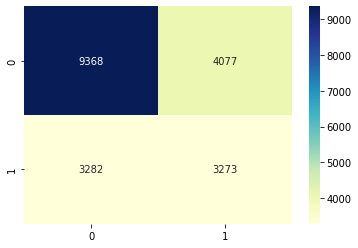

In [70]:
get_clf_eval(y_valid, y_pred_array>0.3)

## Linear Regression()

In [ ]:
reg_model = LinearRegression()

In [ ]:
reg_model.fit(X_train_sc, y_train)

LinearRegression()

In [ ]:
y_hat = reg_model.predict(X_valid_sc)

In [ ]:
y_hat = y_hat>0.3

In [ ]:
df_predictions = pd.DataFrame({'actuals':y_valid, 'predictions':y_hat, 'resid': y_valid - y_hat})
change = {True:1, False:0}
df_predictions.predictions = df_predictions.predictions.map(change)
df_predictions.head()

,actuals,predictions,resid
86605,1,0,1
67931,0,0,0
65523,0,0,0
21787,0,0,0
68815,1,1,0


In [ ]:
acc_reg = df_predictions[df_predictions['resid']==0].shape[0] / df_predictions.shape[0] * 100 
acc_reg

64.795

In [ ]:
reg_model.coef_

array([ 0.15701945, -0.00526872,  0.03308215,  0.01558603, -0.00580517,
       -0.02015316, -0.02757787,  1.45755628, -1.12049107,  0.06038941,
        0.02331513, -0.23135743, -0.01088862, -0.15222726, -2.28034324,
        2.24417722])

In [ ]:
reg_model.coef_.shape

(16,)

In [ ]:
reg_model.intercept_

0.32657500000000017

In [ ]:
reg_summary = pd.DataFrame(data = X_train.columns, columns=['Features'])
reg_summary ['Coefficients'] = np.round(reg_model.coef_,4)
reg_summary

,Features,Coefficients
0,int_rate,0.1570
1,annual_inc,-0.0053
2,dti,0.0331
3,inq_last_6mths,0.0156
4,revol_bal,-0.0058
5,total_acc,-0.0202
6,tot_cur_bal,-0.0276
7,funded_amnt,1.4576
8,funded_amnt_inv,-1.1205
9,total_rec_late_fee,0.0604


## Elastic Net

In [ ]:
from sklearn.linear_model import Lasso,ElasticNet,Ridge

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_sc, y_train)
pred = lasso.predict(X_valid_sc)

y_pred_array = pred
get_clf_eval(y_valid, y_pred_array>0.3)



정확도: 0.6466
정밀도: 0.4702
재현율: 0.7664
AUC: 0.6780
F1: 0.5829


In [ ]:
y_pred_array

tensor([0.5641, 0.5334, 0.5771,  ..., 0.6337, 0.6442, 0.4832])

In [ ]:
pred.shape

(20000,)

## Data 편향 제거 처리

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27) 
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

In [ ]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smt==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smt==1)))

After OverSampling, counts of label '0': 53930
After OverSampling, counts of label '1': 53930


In [ ]:
X_train_smt.head()

,int_rate,annual_inc,dti,inq_last_6mths,revol_bal,total_acc,tot_cur_bal,funded_amnt,funded_amnt_inv,total_rec_late_fee,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high
0,0.0917,70000.0,17.50,0,4577,16,35757,8000,8000.0,0.00,5,255.04,0.870,392.34,660,664
1,0.1899,85000.0,23.11,1,45406,31,327652,23850,23850.0,0.00,18,874.13,0.929,6243.43,660,664
2,0.0916,65000.0,25.48,0,16100,16,48197,17000,17000.0,0.00,10,541.87,0.531,1196.65,690,694
3,0.0818,60000.0,24.26,0,15712,18,50411,12000,12000.0,0.00,12,377.04,0.790,1567.73,670,674
4,0.2099,48000.0,37.53,2,11984,11,33598,15000,15000.0,20.29,9,405.72,0.599,9265.08,665,669


In [ ]:
type(y_train_smt)

pandas.core.series.Series

In [ ]:
train_data_smt = TrainData(torch.FloatTensor(X_train_smt), torch.FloatTensor(y_train_smt.to_numpy()))
valid_data_smt = ValidData(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.to_numpy()))

ValueError: ignored

In [ ]:
EPOCHS = 500
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

# data loader 세팅
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1)

In [ ]:
# Training

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if e % 100 == 1:
      print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
# SMOTE - 오히려 더 감소하는 경향
# get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.4) #0.6166
# get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.35)  #0.6288
get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.3)  #0.6299


정확도: 0.7006
정밀도: 0.5304
재현율: 0.7753
AUC: 0.7197
F1: 0.6299


## 제출

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.35
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_5.csv', index=False)

In [ ]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
